In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
#from keras.applications.resnet50 import ResNet50

2021-10-09 09:35:56.316287: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/slurm/current/lib/slurm:/cm/shared/slurm/current/lib:/cm/shared/slurm/current/lib/slurm:/cm/shared/slurm/current/lib
2021-10-09 09:35:56.316330: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import cv2
import pathlib
from shutil import copyfile
import shutil
import random
from os import path
from PIL import Image, ImageOps

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt 
import numpy as np
import random
from skimage.util import random_noise
import tensorflow as tf
from tensorflow import keras

# Re-sizing and padding 

In [ ]:
def resize_with_padding(img, expected_size):
    img.thumbnail((expected_size[0], expected_size[1]))
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)

def resize(img,expected_size):
    return ImageOps.fit(img,expected_size,method=Image.LANCZOS)
img_height = 224
img_width = 224
def resize_images(img_height,img_width,image_list):
    for image_path in image_list:
        image = cv2.imread(str(image_path))
        img = Image.open(str(image_path))
        (h, w, c) = image.shape[:3]
        if (h<img_height):
            img = resize_with_padding(img, (img_height, img_width))
        else:
            img = resize(img, (img_height, img_width))
        img.save(str(image_path))
        
data_dir = pathlib.Path("/hpc/projects/upt/LangModel/CFU/resnet/iteration6/test")  
cfu = list(data_dir.glob('cfu/*'))
mold = list(data_dir.glob('mold/*'))
resize_images(img_height,img_width,cfu)
resize_images(img_height,img_width,mold)

In [3]:

train_path = '/hpc/projects/upt/LangModel/CFU/resnet/iteration6/test'   #zero padded images train



# Inception_model

In [4]:
pre_trained_model = InceptionV3(input_shape = (299, 299, 3), # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')

2021-10-07 03:54:34.855906: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/slurm/current/lib/slurm:/cm/shared/slurm/current/lib:/cm/shared/slurm/current/lib/slurm:/cm/shared/slurm/current/lib
2021-10-07 03:54:34.856052: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/slurm/current/lib/slurm:/cm/shared/slurm/current/lib:/cm/shared/slurm/current/lib/slurm:/cm/shared/slurm/current/lib
2021-10-07 03:54:34.856115: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/

In [5]:
for layer in pre_trained_model.layers:
    
    layer.trainable = False

In [6]:

x = layers.Flatten()(pre_trained_model.output)

x = layers.Dense(64, activation='relu')(x)

x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ["accuracy"])

In [7]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Data Split into train and val

In [8]:
import tensorflow as tf
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_path,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(299, 299),
  batch_size=32)

Found 207 files belonging to 2 classes.
Using 187 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_path,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(299, 299),
  batch_size=32)

Found 207 files belonging to 2 classes.
Using 20 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['cfu', 'mold']


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

2021-10-07 03:55:07.393234: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


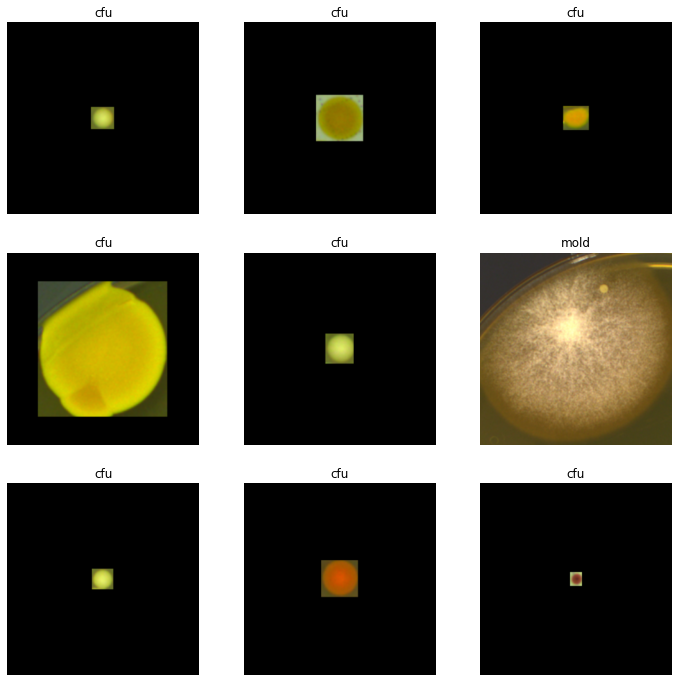

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        #print(images[i].numpy().astype("uint8").shape)
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Model Fit

In [ ]:
file_path="inception6_weights.best.hdf5"

checkpoint = ModelCheckpoint(file_path, monitor='accuracy', verbose=1, save_best_only=True, mode='max')

early = EarlyStopping(monitor="accuracy", mode="max", patience=15)

callbacks_list = [checkpoint, early] #early

# fit the model
# Run the cell. It will take some time to execute
history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = 50,
  verbose =True,
  callbacks = callbacks_list
)


In [ ]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

# Save model

In [3]:
saved_model = tf.keras.models.load_model('inception6_weights.best.hdf5')

# Prediction

In [ ]:
def resize_with_padding(img, expected_size):
    img.thumbnail((expected_size[0], expected_size[1]))
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)

def resize(img,expected_size):
    return ImageOps.fit(img,expected_size,method=Image.LANCZOS)
img_height = 224
img_width = 224
def resize_images(img_height,img_width,image_list):
    for image_path in image_list:
        image = cv2.imread(str(image_path))
        img = Image.open(str(image_path))
        (h, w, c) = image.shape[:3]
        if (h<img_height):
            img = resize_with_padding(img, (img_height, img_width))
        else:
            img = resize(img, (img_height, img_width))
        img.save(str(image_path))
        
data_dir = pathlib.Path("/hpc/projects/upt/LangModel/CFU/resnet/iteration6/test")  #cropped test image path
cfu = list(data_dir.glob('cfu/*'))
mold = list(data_dir.glob('mold/*'))
resize_images(img_height,img_width,cfu)
resize_images(img_height,img_width,mold)

In [115]:
ctr=0
test_img=[]
y = []
test_cfu_dir = "/hpc/projects/upt/LangModel/CFU/resnet/iteration6/test/cfu"  #zero padded cfu and mold images
test_mold_dir = "/hpc/projects/upt/LangModel/CFU/resnet/iteration6/test/mold"
for file_name in os.listdir(test_cfu_dir):
    test_img.append(os.path.join(test_cfu_dir,file_name))
    ctr+=1
    y.append(0)
print(ctr)

for file_name in os.listdir(test_mold_dir):
    test_img.append(os.path.join(test_mold_dir,file_name))
    ctr+=1
    y.append(1)
y = np.array(y)
print(ctr)

85
90


In [116]:
img_width =299
img_height =299

In [117]:
y_pred=[]
for test_image_path in test_img:
    img = tf.keras.utils.load_img(
        test_image_path, target_size=(img_width, img_height)
    )
    img_array = keras.preprocessing.image.img_to_array(img) 
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    #print(img_array.shape)

    predictions = saved_modelmodel.predict(img_array)
    score = predictions[0]
    #print(score)
    if (score<0.5):
        y_pred.append(0)
    else:
        y_pred.append(1)

In [118]:
import sklearn
from sklearn import metrics
from sklearn.metrics import classification_report,f1_score, accuracy_score, confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1.2
    #print(thresh)
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black" )
    fig.tight_layout()
    return ax
def print_evaluation_metrics(y_pred,y_test):

    print('accuracy %s' % accuracy_score(y_pred, y_test).round(2))
    print('f1-score %s' % f1_score(y_pred, y_test,average='weighted').round(2))
    print(classification_report(y_test, y_pred,target_names = target_names))
    print(metrics.confusion_matrix(y_test,y_pred))
    print("MCC score:")
    print(metrics.matthews_corrcoef(y_test, y_pred).round(2))


accuracy 1.0
f1-score 1.0
              precision    recall  f1-score   support

         cfu       1.00      1.00      1.00        85
        mold       1.00      1.00      1.00         5

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90

[[85  0]
 [ 0  5]]
MCC score:
1.0


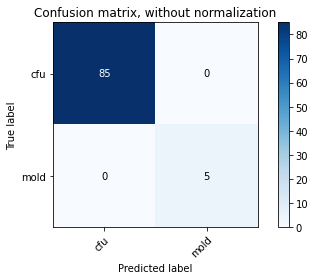

In [120]:
plot_confusion_matrix(y,y_pred,classes=['cfu','mold'])
target_names=['cfu','mold']
print_evaluation_metrics(y_pred,y)

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12569195138053613504
]


2021-10-06 06:12:19.797892: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-06 06:12:20.228274: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/slurm/current/lib/slurm:/cm/shared/slurm/current/lib:/cm/shared/slurm/current/lib/slurm:/cm/shared/slurm/current/lib
2021-10-06 06:12:20.228358: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/slurm/current/lib/slurm:/cm